## **Supervised Learning - Weather and Energy Demand**

In this project, we will be using supervised learning methods to predict how well weather components can predict energy demand.

### **Data Linkage and Merge Dataset**


In [2]:
import pandas as pd
import datetime

In [3]:
melb_df = pd.read_csv("weather_melbourne.csv")
pdd_df = pd.read_csv("price_demand_data.csv")

First, we will convert the date formats. The date format for weather dataset is YYYY-MM-DD. We convert this to YYYY/MM/DD, which matches the date format for energy demand dataset.

In [4]:
# Change Date Format for Data Linkage
date = melb_df["Date"]
melb_df.drop(labels="Date", axis=1, inplace=True)
new_date_format = []
for value in date:
    value = datetime.datetime.strptime(str(value), "%Y-%m-%d").strftime("%Y/%m/%d")
    new_date_format.append(value)
melb_df.insert(0, "Date", new_date_format)

We are only interested in the data regarding the energy demand in Victoria, so we filter the dataset. We also modified the data format to only include the date and exclude the time. Next, we find the mean energy demand for each day.

In [5]:
# Filter out Melbourne Data
pdd_melb = pdd_df[pdd_df["REGION"] == "VIC1"]

# Change date format to daily date
date_list = []
for date in pdd_melb["SETTLEMENTDATE"]:
    date_list.append(date[:-9])
pdd_melb.insert(1, "Date", date_list)

# Find mean of energy for each day 
pdd_melb = round(pdd_melb.groupby("Date")["TOTALDEMAND"].mean(), 2)
pdd_melb.rename("TOTAL DEMAND", inplace=True)
pdd_melb.to_csv("pdd_melb.csv")

Now, we merge the data using inner join.

In [6]:
# Merge Data (Weather and Energy Demand)
pdd_df = pd.read_csv("pdd_melb.csv")
merged_data = pd.merge(melb_df, pdd_df, how='inner')
print(merged_data)

           Date  Minimum temperature (°C)  Maximum temperature (°C)  \
0    2021/02/01                      13.4                      20.3   
1    2021/02/02                      14.5                      19.3   
2    2021/02/03                      13.7                      25.9   
3    2021/02/04                      13.5                      30.6   
4    2021/02/05                      17.3                      29.8   
..          ...                       ...                       ...   
406  2022/03/14                      16.4                      28.0   
407  2022/03/15                      18.3                      27.5   
408  2022/03/16                      18.9                      23.2   
409  2022/03/17                      17.7                      29.2   
410  2022/03/18                      19.1                      21.7   

     Rainfall (mm)  Evaporation (mm)  Sunshine (hours)  \
0              0.0               7.4               1.6   
1              0.0             

-------------------------

### **Divide Dataset to Training and Testing**

After merging, we divide the dataset to training (80%) and testing (20%). We will continue to preprocess the training data first.

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(merged_data, test_size=0.2)

train_data.to_csv("training_melb_weather.csv")
test_data.to_csv("testing_melb_weather.csv")

-------------------------

### **Preprocessing the Training Dataset**

In [8]:
import numpy as np
import matplotlib.pyplot as plt

We will start preprocessing the dataset by first filtering the data that we are interested in, which is quantitative data. Then, we deal with missing values by imputing them with the mean value

In [9]:
melb_df = pd.read_csv("training_melb_weather.csv")

# Filter data: Only interested in Quantitative Data
melb_weather = melb_df[["Date", "Minimum temperature (°C)", "Maximum temperature (°C)", "Rainfall (mm)", "Evaporation (mm)", 
"Sunshine (hours)", "Speed of maximum wind gust (km/h)"]]

# Missing Values: Impute Missing Values with Mean Data
melb_imputed = melb_weather[["Minimum temperature (°C)", "Maximum temperature (°C)", "Rainfall (mm)", "Evaporation (mm)", 
"Sunshine (hours)", "Speed of maximum wind gust (km/h)"]]
melb_imputed = melb_imputed.fillna(melb_imputed.mean())


Now, we will also find the mean temperature for processing during a later stage. We use the formula $$\frac{maximum  +  minimum}{2} \\ $$, where maximum is the maximum temperature and minimum is minimum temperature. We will also include the date.


In [10]:
# Find Mean Temperature Value and Insert to Dataframe
mean_temp = []
for i in range(len(melb_imputed)):
    mean_temp.append((melb_imputed["Minimum temperature (°C)"][i] + melb_imputed["Maximum temperature (°C)"][i])/2)
melb_imputed.insert(2, "Mean Temperature (°C)", mean_temp)

# Include date 
melb_imputed.insert(0, "Date", melb_weather["Date"])
melb_imputed.set_index("Date", drop=True, inplace=True)
melb_imputed.to_csv("melb_weather.csv")

Next, we will normalize the values.

In [11]:
# Normalize: Rescale the values to be between 0 and 1
melb_normalized = (melb_imputed - melb_imputed.min()) / (melb_imputed.max() - melb_imputed.min())

# Output pre-processed normalized Melbourne Weather Dataset as csv
melb_normalized.to_csv("melb_weather_normalized.csv") 


We will also normalize the energy demand dataset.

In [12]:
#Get and normalize price demand datas
pdd_melb = melb_df[["Date", "TOTAL DEMAND"]]

# Output pre-processed Melbourne Price Demand Dataset as csv
pdd_melb.to_csv("new_pdd_melb.csv")

# Normalize: Rescale the values to be between 0 and 1
pdd_melb_normalized = (pdd_melb["TOTAL DEMAND"] - pdd_melb["TOTAL DEMAND"].min()) / (pdd_melb["TOTAL DEMAND"].max() - pdd_melb["TOTAL DEMAND"].min())
pdd_melb.insert(1, "Normalized", pdd_melb_normalized)
pdd_melb.to_csv("pdd_melb_normalized.csv")

---------------------------

### **Visualization**

In this section, we will visualize various weather components against the energy demand.

First, we will visualize minimum temperature (°C) against the energy demand (kWh).

From this plot, we can see a correlation between minimum temperature and energy demand, although it is not linear, but U-shaped.

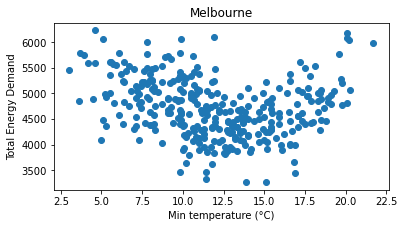

In [13]:
melb_df = pd.read_csv("melb_weather.csv")
pdd_melb_df = pd.read_csv("pdd_melb.csv")
mintemp_demand = pd.merge(melb_df[["Date", "Minimum temperature (°C)"]], pdd_melb_df, how='inner')
mintemp_demand.set_index("Date", inplace=True)
 
plt.scatter(mintemp_demand["Minimum temperature (°C)"], mintemp_demand["TOTAL DEMAND"])
plt.xlabel("Min temperature (°C)")
plt.ylabel("Total Energy Demand")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_mintemp_demand_melb.png")
plt.show()
plt.close()

Second, we plot the mean temperature (°C), that we calculated previously, against the energy demand (kWh).  A u-shaped (open parabola-like) correlation can be observed. The high energy demands occur during periods of low and high temperature, while low energy demands occur when temperature is not too hot or cold.

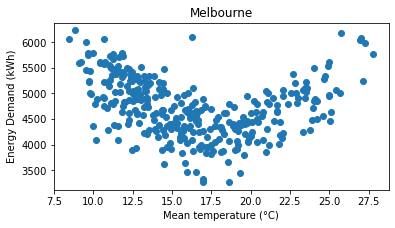

In [14]:
temp_demand = pd.merge(melb_df[["Date", "Mean Temperature (°C)"]], pdd_melb_df, how='inner')
temp_demand.set_index("Date", inplace=True)
 
plt.scatter(temp_demand["Mean Temperature (°C)"], temp_demand["TOTAL DEMAND"])
plt.xlabel("Mean temperature (°C)")
plt.ylabel("Energy Demand (kWh)")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_temp_demand_melb.png")
plt.show()
plt.close()

Third, we plot the maximum temperature against energy demand. We observe a similar relationship between energy demand and maximum temperature, as minimum and mean temperature. However, the correlation seems weaker than the mean temperature.

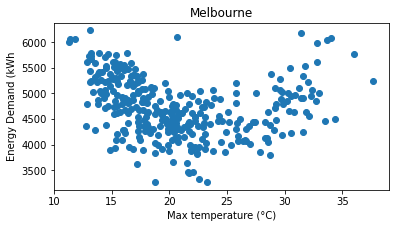

In [15]:
maxtemp_demand = pd.merge(melb_df[["Date", "Maximum temperature (°C)"]], pdd_melb_df, how='inner')
maxtemp_demand.set_index("Date", inplace=True)

plt.scatter(maxtemp_demand["Maximum temperature (°C)"], maxtemp_demand["TOTAL DEMAND"])
plt.xlabel("Max temperature (°C)")
plt.ylabel("Energy Demand (kWh")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_maxtemp_demand_melb.png")
plt.show()
plt.close()

Next, we will visualize the speed of maximum wind gust (km/h) against demand (kWh). 

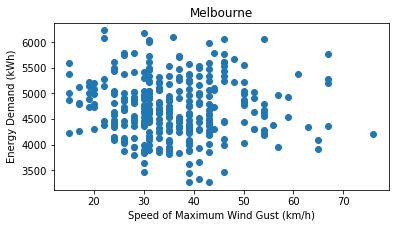

In [16]:
windspeed_demand = pd.merge(melb_df[["Date", "Speed of maximum wind gust (km/h)"]], pdd_melb_df, how='inner')
windspeed_demand.set_index("Date", inplace=True)

plt.scatter(windspeed_demand["Speed of maximum wind gust (km/h)"], windspeed_demand["TOTAL DEMAND"])
plt.xlabel("Speed of Maximum Wind Gust (km/h)")
plt.ylabel("Energy Demand (kWh)")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_windspeed_demand_melb.png")
plt.show()
plt.close()

Now, we will visualize sunshine (hours) against energy demand (kWh). Visually, we see that there are no correlations between the two variables.

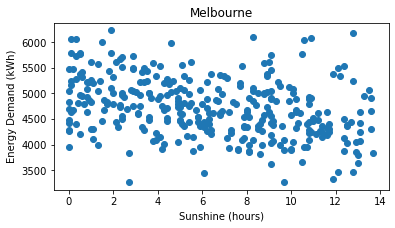

In [17]:
sunshine_demand = pd.merge(melb_df[["Date", "Sunshine (hours)"]], pdd_melb_df, how='inner')
sunshine_demand.set_index("Date", inplace=True)

plt.scatter(sunshine_demand["Sunshine (hours)"], sunshine_demand["TOTAL DEMAND"])
plt.xlabel("Sunshine (hours)")
plt.ylabel("Energy Demand (kWh)")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_sunshine_demand_melb.png")
plt.show()
plt.close()

Next, we visualize rainfall (mm) against energy demand (kWh). We see that in most days, there are zero or little rainfall.

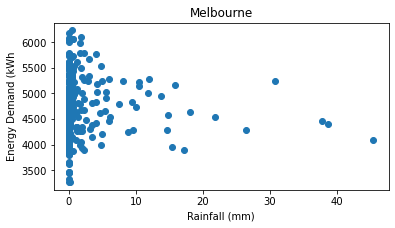

In [18]:
rainfall_demand = pd.merge(melb_df[["Date", "Rainfall (mm)"]], pdd_melb_df, how='inner')
rainfall_demand.set_index("Date", inplace=True)

plt.scatter(rainfall_demand["Rainfall (mm)"], rainfall_demand["TOTAL DEMAND"])
plt.xlabel("Rainfall (mm)")
plt.ylabel("Energy Demand (kWh")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_rainfall_demand_melb.png")
plt.show()
plt.close()

Lastly, we plot the evaporation (mm) against energy demand (kWh). We can see that the lower the evaporation, the higher the energy demand. However, there are also some instances where the evaporation is high and the energy demand is also high. A somewhat weak u-shaped correlation can be observed.

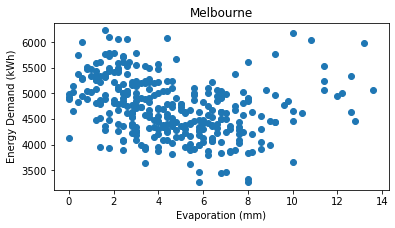

In [19]:
evaporation_demand = pd.merge(melb_df[["Date", "Evaporation (mm)"]], pdd_melb_df, how='inner')
evaporation_demand.set_index("Date", inplace=True)

plt.scatter(evaporation_demand["Evaporation (mm)"], evaporation_demand["TOTAL DEMAND"])
plt.xlabel("Evaporation (mm)")
plt.ylabel("Energy Demand (kWh)")
plt.title("Melbourne")
plt.subplots_adjust(bottom=0.3)
plt.savefig("unnorm_evaporation_demand_melb.png")
plt.show()
plt.close()


After visualization, we can see that temperature (minimum, mean and maximum) shows the most correlation with the energy demand. The correlation is not linear, but U-shaped. Lower and higher temperatures correspond to high energy demand, while moderate temperatures correspond to low energy demand.

------------------------------------------------

### **General Statistics**

We can also explore some general statistics of our dataset, such as the mean, standard deviation and more. From exploring these statistics, we gain a better feel and understanding of our dataset as a whole.

In [20]:
melb_nn = pd.merge(melb_df, pdd_melb_df, how='inner')
stats = melb_nn.describe()
print(stats)

       Minimum temperature (°C)  Maximum temperature (°C)  \
count                328.000000                328.000000   
mean                  11.906116                 20.657187   
std                    3.967956                  5.620202   
min                    3.000000                 11.300000   
25%                    9.100000                 16.200000   
50%                   11.500000                 19.750000   
75%                   14.900000                 23.525000   
max                   21.700000                 37.700000   

       Mean Temperature (°C)  Rainfall (mm)  Evaporation (mm)  \
count             328.000000     328.000000        328.000000   
mean               16.281651       1.786544          4.608232   
std                 4.434768       5.343818          2.778086   
min                 8.450000       0.000000          0.000000   
25%                12.687500       0.000000          2.400000   
50%                15.750000       0.000000          4.20000

-------------------------

### **Feature Selection**

In this section, we will conduct feature selection. We want to only select features that has a relationship with the energy demand. This would reduce the number of input variables when we develop our model.

Previously, during visualization, we see that none of the weather components have a linear relationship with the energy demand. We can only see an u-shaped relationship. Therefore, we cannot use Pearson's correlation to determine whether a weather component correlates well with energy demand. Instead, we will use mutual information, to find the "amount of information" obtained about energy demand by observing each weather component. The higher the mutual information, the more the weather component tells us more information about the energy demand.

### Discretization

Before we can compute mutual information, we should discretize our continuous data first. To determine the number of bins to discretize our data, we use the Freedman-Diaconis rule, which is :

$$\frac{max-min}{h} \\ $$ where h is
$$ 2*IQR*n^{-1/3}$$

In [21]:
from sklearn.preprocessing import KBinsDiscretizer
melb_bins = melb_nn
for feature in melb_bins.iloc[:,1:]:
    q3, q1 = np.percentile(melb_bins[feature], [75, 25])
    iqr = q3 - q1
    h = 2 * iqr / len(melb_bins)**(1/3)
    bins = int((melb_bins[feature].max() - melb_bins[feature].min()) / h) # Find number of bins
    print(feature, bins)
    equal_width = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    melb_bins["Binned " + feature] = equal_width.fit_transform(melb_bins[feature].to_numpy().reshape(-1, 1)).astype(int)
print(melb_bins)

Minimum temperature (°C) 11
Maximum temperature (°C) 12
Mean Temperature (°C) 9
Rainfall (mm) 195
Evaporation (mm) 11
Sunshine (hours) 7
Speed of maximum wind gust (km/h) 19
TOTAL DEMAND 13
           Date  Minimum temperature (°C)  Maximum temperature (°C)  \
0    2021/03/07                      11.3                      28.5   
1    2021/08/21                      10.6                      20.0   
2    2021/10/01                      13.6                      22.2   
3    2021/09/05                       8.3                      13.6   
4    2021/09/15                       5.3                      15.9   
..          ...                       ...                       ...   
323  2021/11/22                      10.2                      20.8   
324  2021/05/24                       6.8                      19.9   
325  2022/02/24                      19.3                      22.7   
326  2021/06/20                       5.2                      14.5   
327  2022/01/10              

### Mutual Information

Now, we will calculate the mutual information between each weather component and the total demand. We set the threshold to be 0.2. If the mutual information is lower than the threshold, then we assume that the weather component does not predict energy demand. Thus, we exclude those components and only select features that have higher MI than the threshold.

In [22]:
from sklearn.feature_selection import mutual_info_classif

In [23]:
filtered_features = []
THRESHOLD = 0.2
features = melb_bins[["Binned Minimum temperature (°C)", "Binned Maximum temperature (°C)", "Binned Mean Temperature (°C)", "Binned Rainfall (mm)", "Binned Evaporation (mm)", "Binned Sunshine (hours)", "Binned Speed of maximum wind gust (km/h)", "Binned TOTAL DEMAND"]]
class_label = melb_bins["Binned TOTAL DEMAND"]
mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    if(mi >= THRESHOLD): 
        filtered_features.append(feature)
        
print('\nFeature set after filtering with MI:', filtered_features)

filtered_data = []
for feature in filtered_features:
    filtered_data.append(melb_bins[feature])
filtered_melb = (pd.DataFrame(filtered_data)).T
demand = melb_bins["Binned TOTAL DEMAND"]
filtered_melb.insert(0, "Binned_Total_Demand", demand)
filtered_melb.to_csv("filtered_melb_weather.csv")

MI value for feature "Binned Minimum temperature (°C)": 0.3076
MI value for feature "Binned Maximum temperature (°C)": 0.3888
MI value for feature "Binned Mean Temperature (°C)": 0.4121
MI value for feature "Binned Rainfall (mm)": 0.4386
MI value for feature "Binned Evaporation (mm)": 0.2931
MI value for feature "Binned Sunshine (hours)": 0.1856
MI value for feature "Binned Speed of maximum wind gust (km/h)": 0.3063
MI value for feature "Binned TOTAL DEMAND": 2.3116

Feature set after filtering with MI: ['Binned Minimum temperature (°C)', 'Binned Maximum temperature (°C)', 'Binned Mean Temperature (°C)', 'Binned Rainfall (mm)', 'Binned Evaporation (mm)', 'Binned Speed of maximum wind gust (km/h)', 'Binned TOTAL DEMAND']


## **KNN Model with K-fold cross validation**

We have conducted most of the data wrangling. However, there is one step left in our data wrangling process. That is, we have to discretize our data again, but with a non-variable number of bins. This is because the training and testing data have different lengths, while the number of bins for both data should be the same.

In [24]:
melb_df = pd.read_csv("melb_weather_normalized.csv")
pdd_melb_df = pd.read_csv("pdd_melb_normalized.csv")
melb_n = pd.merge(melb_df, pdd_melb_df, how='inner')
# Select only filtered features
melb_n =  melb_n[['Minimum temperature (°C)', 'Mean Temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Speed of maximum wind gust (km/h)', 'TOTAL DEMAND']]
features_dict = {'Minimum temperature (°C)': 5, "Mean Temperature (°C)": 5, "Maximum temperature (°C)": 5, "Rainfall (mm)": 5, "Evaporation (mm)": 5, "Speed of maximum wind gust (km/h)": 5, "TOTAL DEMAND": 5}
#features_dict = {'Minimum temperature (°C)': 10, "Mean Temperature (°C)": 10, "Maximum temperature (°C)": 10, "Rainfall (mm)": 10, "Evaporation (mm)": 10, "Speed of maximum wind gust (km/h)": 10, "TOTAL DEMAND": 10}

for feature in melb_n.iloc[:,0:]:
    equal_width = KBinsDiscretizer(n_bins=features_dict[feature], encode='ordinal', strategy='uniform')
    melb_n["Binned " + feature] = equal_width.fit_transform(melb_n[feature].to_numpy().reshape(-1, 1)).astype(int)

print(melb_n)

     Minimum temperature (°C)  Mean Temperature (°C)  \
0                    0.443850               0.591731   
1                    0.406417               0.354005   
2                    0.566845               0.488372   
3                    0.283422               0.129199   
4                    0.122995               0.111111   
..                        ...                    ...   
323                  0.385027               0.364341   
324                  0.203209               0.253230   
325                  0.871658               0.648579   
326                  0.117647               0.072351   
327                  0.668449               0.775194   

     Maximum temperature (°C)  Rainfall (mm)  Evaporation (mm)  \
0                    0.651515       0.000000          0.441176   
1                    0.329545       0.022026          0.264706   
2                    0.412879       0.480176          0.205882   
3                    0.087121       0.211454          0.323529 

Now, we are ready to create our model. First, we proceed by conducting a K-fold cross validation to set up the optimal hyperparameters.

### K-fold Cross Validation

In [25]:
from sklearn.model_selection import KFold 

In [26]:
kf_CV = KFold(n_splits=10, shuffle=True, random_state=4)
data_train = melb_n
# Choice of x_cols explained in report
x_cols = ["Binned Mean Temperature (°C)", "Binned Evaporation (mm)"]
#x_cols = ["Binned Minimum temperature (°C)", "Binned Mean Temperature (°C)", "Binned Maximum temperature (°C)", "Binned Evaporation (mm)", "Binned Speed of maximum wind gust (km/h)"]
y_cols = "Binned TOTAL DEMAND"
X = data_train[x_cols]
Y = data_train[y_cols]

### K Nearest Neigbour

Now, we set up the KNN model. First, we use k = 1.

In [27]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score
from statistics import mean

In [28]:
# KNN with k = 1
results = []
for train_index, test_index in kf_CV.split(X):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    for index in train_index:
        X_train.append(X.iloc[index])
        X_test.append(X.iloc[index])
        Y_train.append(Y.iloc[index])
        Y_test.append(Y.iloc[index])
    # Training
    knn = KNN(n_neighbors=1)
    knn.fit(X_train, Y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(Y_test, y_pred))
print("Mean Accuracy of k = 1: ", mean(results))


Mean Accuracy of k = 1:  0.40073866239120476


Second, we try k=3.

In [29]:
# KNN with k = 3
results = []
for train_index, test_index in kf_CV.split(X):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    for index in train_index:
        X_train.append(X.iloc[index])
        X_test.append(X.iloc[index])
        Y_train.append(Y.iloc[index])
        Y_test.append(Y.iloc[index])
            
    # Training
    knn = KNN(n_neighbors=3)
    knn.fit(X_train, Y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(Y_test, y_pred))
print("Mean Accuracy of k = 3: ", mean(results))


Mean Accuracy of k = 3:  0.43154145671094823


We also try k = 5.

In [30]:
# KNN with k = 5
results = []
for train_index, test_index in kf_CV.split(X):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    for index in train_index:
        X_train.append(X.iloc[index])
        X_test.append(X.iloc[index])
        Y_train.append(Y.iloc[index])
        Y_test.append(Y.iloc[index])
            
    # Training
    knn = KNN(n_neighbors=5)
    knn.fit(X_train, Y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(Y_test, y_pred))
print("Mean Accuracy of k = 5: ", mean(results))


Mean Accuracy of k = 5:  0.4461245991754466


Finally, let's try k = 10.

In [31]:
# KNN with k = 10
results = []
for train_index, test_index in kf_CV.split(X):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    for index in train_index:
        X_train.append(X.iloc[index])
        X_test.append(X.iloc[index])
        Y_train.append(Y.iloc[index])
        Y_test.append(Y.iloc[index])
            
    # Training
    knn = KNN(n_neighbors=10)
    knn.fit(X_train, Y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(Y_test, y_pred))
print("Mean Accuracy of k = 10: ", mean(results))

Mean Accuracy of k = 10:  0.47357879065506187


-------------------------

### Pre-processing of Testing data

Before we can do testing, we first pre-process our testing data the same way we pre-processed our training data.

In [32]:
melb_df_test = pd.read_csv("testing_melb_weather.csv")

# Filter data: Only interested in Quantitative, Filtered Data
melb_weather_test = melb_df_test[["Date", "Minimum temperature (°C)", "Maximum temperature (°C)", "Rainfall (mm)", "Evaporation (mm)", "Speed of maximum wind gust (km/h)"]]

# Missing Values: Impute Missing Values with Mean Data
melb_imputed_test = melb_weather_test[["Minimum temperature (°C)", "Maximum temperature (°C)", "Rainfall (mm)", "Evaporation (mm)", "Speed of maximum wind gust (km/h)"]]
melb_imputed_test = melb_imputed_test.fillna(melb_imputed_test.mean())

# Find Mean Temperature Value and Insert to Dataframe
mean_temp_test = []
for i in range(len(melb_imputed_test)):
    mean_temp_test.append((melb_imputed_test["Minimum temperature (°C)"][i] + melb_imputed_test["Maximum temperature (°C)"][i])/2)
melb_imputed_test.insert(2, "Mean Temperature (°C)", mean_temp_test)

# Include date 
melb_imputed_test.insert(0, "Date", melb_weather_test["Date"])
melb_imputed_test.set_index("Date", drop=True, inplace=True)
melb_imputed_test.to_csv("melb_weather_test.csv")

# Normalize: Rescale the values to be between 0 and 1
melb_normalized_test = (melb_imputed_test - melb_imputed_test.min()) / (melb_imputed_test.max() - melb_imputed_test.min())

# Output pre-processed normalized Melbourne Weather Dataset as csv
melb_normalized_test.to_csv("melb_weather_normalized_test.csv") 

#Get and normalize price demand datas
pdd_melb_test = melb_df_test[["Date", "TOTAL DEMAND"]]

# Output pre-processed Melbourne Price Demand Dataset as csv
pdd_melb_test.to_csv("new_pdd_melb.csv")

# Normalize: Rescale the values to be between 0 and 1
pdd_melb_normalized_test = (pdd_melb_test["TOTAL DEMAND"] - pdd_melb_test["TOTAL DEMAND"].min()) / (pdd_melb_test["TOTAL DEMAND"].max() - pdd_melb_test["TOTAL DEMAND"].min())
pdd_melb_test.insert(1, "Normalized", pdd_melb_normalized_test)
pdd_melb_test.to_csv("pdd_melb_normalized_test.csv")

---

### **Testing our KNN Model**

Now, we can test our KNN Model with our pre-processed testing dataset

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [34]:
melb_df_test = pd.read_csv("melb_weather_normalized_test.csv")
pdd_melb_df_test = pd.read_csv("pdd_melb_normalized_test.csv")
melb_n_test = pd.merge(melb_df_test, pdd_melb_df_test, how='inner')

# Select only filtered features
melb_n_test =  melb_n_test[['Minimum temperature (°C)', 'Mean Temperature (°C)', 'Maximum temperature (°C)', 'Rainfall (mm)', 'Evaporation (mm)', 'Speed of maximum wind gust (km/h)', 'TOTAL DEMAND']]
features_dict = {'Minimum temperature (°C)': 5, "Mean Temperature (°C)": 5, "Maximum temperature (°C)": 5, "Rainfall (mm)": 5, "Evaporation (mm)": 5, "Speed of maximum wind gust (km/h)": 5, "TOTAL DEMAND": 5}
#features_dict = {'Minimum temperature (°C)': 10, "Mean Temperature (°C)": 10, "Maximum temperature (°C)": 10, "Rainfall (mm)": 10, "Evaporation (mm)": 10, "Speed of maximum wind gust (km/h)": 10, "TOTAL DEMAND": 10}

# Discretize using the same amount of bins
for feature in melb_n_test.iloc[:,0:]:
    equal_width = KBinsDiscretizer(n_bins=features_dict[feature], encode='ordinal', strategy='uniform')
    melb_n_test["Binned " + feature] = equal_width.fit_transform(melb_n_test[feature].to_numpy().reshape(-1, 1)).astype(int)


For further analysis, we also plotted the distribution of energy demand.

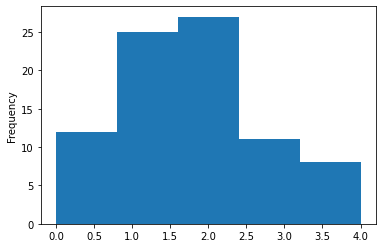

In [35]:
melb_td = melb_n_test["Binned TOTAL DEMAND"]
melb_td.plot.hist(bins=5)
plt.show()
plt.savefig("Distribution_demand.png")
plt.close()

In [36]:
data_test = melb_n_test
#x_cols = "Binned Mean Temperature (°C)"
x_cols = ["Binned Mean Temperature (°C)", "Binned Evaporation (mm)"]
#x_cols = ["Binned Minimum temperature (°C)", "Binned Mean Temperature (°C)", "Binned Maximum temperature (°C)", "Binned Evaporation (mm)", "Binned Speed of maximum wind gust (km/h)"]
y_cols = "Binned TOTAL DEMAND"
X_test = data_test[x_cols]
Y_test = data_test[y_cols]

In [37]:
knn = KNN(n_neighbors=10)
knn.fit(X, Y)  

KNeighborsClassifier(n_neighbors=10)

In [38]:
y_pred = knn.predict(X_test)
accuracy = knn.score(X_test, Y_test)
print('Accuracy', accuracy)
print('Recall: ', recall_score(Y_test, y_pred, average='macro'))
print('Precision: ', precision_score(Y_test, y_pred, average="macro", zero_division=0))

Accuracy 0.40963855421686746
Recall:  0.3050235690235691
Precision:  0.23226214574898787


Although our accuracy may seem rather low, looking at the confusion matrix suggests our model may be better than what the accuracy shows. Since we discretize continuous data, our accuracy scores decrease significantly. However, we see in the confusion matrix that adjacent boxes to the diagonal boxes has a high value. This suggests that our model is able to predict the energy demand over a wider range.

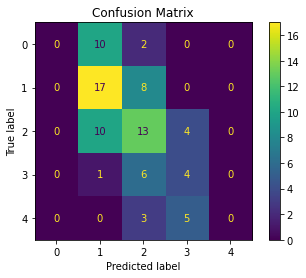

In [39]:
cm = confusion_matrix(Y_test, y_pred, labels=knn.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_).plot()
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()
plt.close()

***

### **Bootstrapping**

In case there is an imbalance in the distribution of classes in our dataset, we also tried the bootstrapping method, setting the number of bins = 5 and bootstrap samples (k) = 10

In [40]:
from sklearn.utils import resample

# Get X, y
X_imb = melb_n_test['Binned Mean Temperature (°C)']
y_imb = np.array(melb_n_test['Binned TOTAL DEMAND'])
X_imb2 = pd.DataFrame(X_imb).to_numpy()

accuracies = []
precisions = []
recalls = []

n = X_imb2.shape[0]
dataidx = range(n)

In [41]:
k = 10

for k in range(10):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=k)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_imb_train = X_imb2[boot_index,:]
    X_imb_test = X_imb2[oob_index,:]
    y_imb_train = y_imb[boot_index]
    y_imb_test = y_imb[oob_index]
    
    # Train
    knn = KNN(n_neighbors=10)
    knn.fit(X_imb_train, y_imb_train)
    
    # Predict
    y_imb_pred=knn.predict(X_imb_test)

    # Evaluate
    accuracies.append(accuracy_score(y_imb_test, y_imb_pred))
    recalls.append(recall_score(y_imb_test, y_imb_pred, average='micro', labels=np.unique(y_imb_pred)))
    precisions.append(precision_score(y_imb_test, y_imb_pred, average='micro', labels=np.unique(y_imb_pred)))

print("Accuracy from each bootstrap sample:", accuracies)
print("Mean accuracy from all bootstrap samples:", np.mean(accuracies))

print("Precision from each bootstrap sample:", precisions)
print("Mean precision from all bootstrap samples:", np.mean(precisions))

print("Recall from each bootstrap sample:", recalls)
print("Mean recall from all bootstrap samples:", np.mean(recalls))

Accuracy from each bootstrap sample: [0.27586206896551724, 0.37037037037037035, 0.36666666666666664, 0.3333333333333333, 0.30303030303030304, 0.2, 0.3055555555555556, 0.1875, 0.3333333333333333, 0.3235294117647059]
Mean accuracy from all bootstrap samples: 0.29991810430197857
Precision from each bootstrap sample: [0.27586206896551724, 0.37037037037037035, 0.36666666666666664, 0.3333333333333333, 0.30303030303030304, 0.2, 0.3055555555555556, 0.1875, 0.3333333333333333, 0.3235294117647059]
Mean precision from all bootstrap samples: 0.29991810430197857
Recall from each bootstrap sample: [0.2857142857142857, 0.7142857142857143, 0.44, 0.5263157894736842, 0.3448275862068966, 0.2692307692307692, 0.5238095238095238, 0.1935483870967742, 0.5555555555555556, 0.5238095238095238]
Mean recall from all bootstrap samples: 0.4377097135182727


---

## **Polynomial Regression**

To further aid us in answering the research question, we also conducted polynomial regression. Through visualizations and calculating mutual information, we find that the weather component that correlates the most with energy demand is mean temperature. Hence, we will conduct regression with mean temperature and energy demand.

In [42]:
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures


In [43]:
# Prepare train and test data
data_train_x = pd.read_csv('melb_weather_normalized.csv')
data_train_y = pd.read_csv('pdd_melb_normalized.csv')
x_cols = "Mean Temperature (°C)"
y_cols = "Normalized"
X = data_train_x[x_cols]
Y = data_train_y[y_cols]

data_test_x = pd.read_csv('melb_weather_normalized_testing.csv')
data_test_y = pd.read_csv('pdd_melb_normalized_testing.csv')
X_test = data_test_x[x_cols]
Y_test = data_test_y[y_cols]
X_test2 = X_test

X = np.array(X)
X = np.reshape(X, (-1,1))
X_test = np.array(X_test)
X_test = np.reshape(X_test, (-1,1))

In [44]:
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X)
polynomial_features= PolynomialFeatures(degree=2)
X_test = polynomial_features.fit_transform(X_test)

model = LinearRegression()
model.fit(x_poly, Y)

LinearRegression()

Let us try to plot a curve on the graph of mean temperature against energy demand

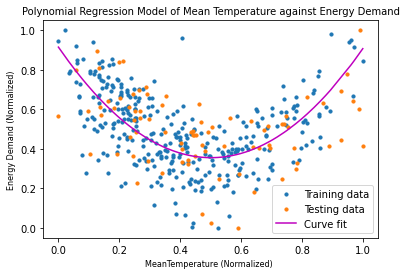

In [45]:
# PLOT 
y_poly_pred = model.predict(x_poly)
plt.scatter(X, Y, s=10, label="Training data")
plt.scatter(X_test2, Y_test, s=10, label="Testing data")

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X,y_poly_pred), key=sort_axis)
X, y_poly_pred = zip(*sorted_zip)
plt.plot(X, y_poly_pred, color='m', label='Curve fit')
leg = plt.legend();
plt.xlabel("MeanTemperature (Normalized) ", fontsize=8)
plt.ylabel("Energy Demand (Normalized)", fontsize=8)
plt.title("Polynomial Regression Model of Mean Temperature against Energy Demand", fontsize=10)
plt.savefig("5.poly_result_temp.png")
plt.show()

Now, we will test our testing set. Here, we produced the $r^2$ value, although this is not a good evaluation for our model since the correlation is non-linear.

In [46]:
# TESTING
y_pred = model.predict(X_test)
r2 = model.score(X_test, Y_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

print('R2:', r2)
print('RMSE:', rmse)

R2: 0.11537788431274609
RMSE: 0.1720214826134744


To aid in understanding our results, we will visualize the actual and predicted values of the model.

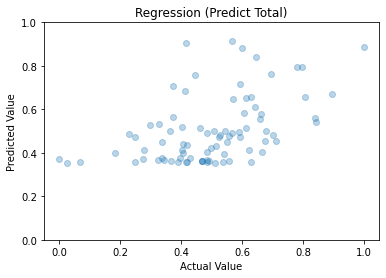

In [47]:
plt.scatter(Y_test, y_pred, alpha=0.3)
plt.title('Regression (Predict Total)')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.ylim(0, 1)
plt.savefig("Actual_VS_Predicted.png")
plt.show()
plt.close()

We will also plot the residuals.

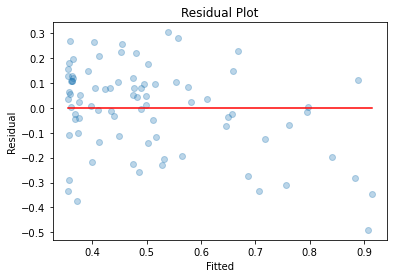

In [48]:
residuals = Y_test - y_pred
# plot residuals
plt.scatter(y_pred, residuals, alpha=0.3)
# plot the 0 line (we want our residuals close to 0)
plt.plot([min(y_pred), max(y_pred)], [0,0], color='red')
plt.title('Residual Plot')
plt.xlabel('Fitted')
plt.ylabel('Residual')
plt.savefig("Residual_png")
